In [ ]:
# !pip3 install dtw-python pandas==1.2.4 sktime==0.5.3

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split

# own libs
from utils import load_from_sktime_univariate, plot_embedding
from embedder import TimeSeriesEmbedder

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
dataset_name = "HandOutlines"

In [ ]:
# load dataset
X_train, y_train = load_from_sktime_univariate(
    f"drive/MyDrive/ColabData/Univariate_ts/{dataset_name}/{dataset_name}_TRAIN.ts"
)
X_test, y_test = load_from_sktime_univariate(
    f"drive/MyDrive/ColabData/Univariate_ts/{dataset_name}/{dataset_name}_TEST.ts"
)

# # balance instances on training/test - only some specific datasets
# X_train, X_test, y_train, y_test = train_test_split(np.concatenate([X_train, X_test]),
#                                                     np.concatenate([y_train, y_test]),
#                                                     test_size=.75, random_state=17)

# remove instances on training - only some specific datasets
X_train, _, y_train, _ = train_test_split(X_train, y_train,
                                          train_size=.1, random_state=17)

In [ ]:
TS_LENGTH = X_train.shape[1]

# embedding is half the size of the original series
EMBEDDING_LENGTH = TS_LENGTH // 2

# neural network params
BATCH_SIZE = 16
EPOCHS = 50

In [ ]:
# store metrics
one_accuracies, three_accuracies = [], []
train_sils, test_sils = [], []

# since neural networks can be unstable (random initialization of the weights), we evalute it three times
for _ in range(3):

    emb = TimeSeriesEmbedder(EMBEDDING_LENGTH, TS_LENGTH)
    emb.fit(X_train, y_train,
            batch_size=BATCH_SIZE, epochs=EPOCHS)
    
    # silhouettes - train and test
    train_sils.append(silhouette_score(emb.encode(X_train), y_train))
    test_sils.append(silhouette_score(emb.encode(X_test), y_test))

    #only one neighbor
    one_y_pred = KNeighborsClassifier(n_neighbors=1,
                                      metric="cosine",
                                      n_jobs=-1).fit(emb.encode(X_train), y_train).predict(emb.encode(X_test))

    one_accuracies.append(accuracy_score(y_test, one_y_pred))

    # three neighbors
    three_y_pred = KNeighborsClassifier(n_neighbors=3,
                                        metric="cosine",
                                        n_jobs=-1).fit(emb.encode(X_train), y_train).predict(emb.encode(X_test))

    three_accuracies.append(accuracy_score(y_test, three_y_pred))

Epoch 1/50
39/39 [==============================] - 22s 369ms/step - loss: 0.6231
Epoch 2/50
39/39 [==============================] - 14s 365ms/step - loss: 0.4300
Epoch 3/50
39/39 [==============================] - 14s 364ms/step - loss: 0.3911
Epoch 4/50
39/39 [==============================] - 14s 363ms/step - loss: 0.4154
Epoch 5/50
39/39 [==============================] - 14s 363ms/step - loss: 0.4037
Epoch 6/50
39/39 [==============================] - 14s 366ms/step - loss: 0.3782
Epoch 7/50
39/39 [==============================] - 14s 364ms/step - loss: 0.4049
Epoch 8/50
39/39 [==============================] - 14s 362ms/step - loss: 0.4370
Epoch 9/50
39/39 [==============================] - 14s 363ms/step - loss: 0.4297
Epoch 10/50
39/39 [==============================] - 14s 362ms/step - loss: 0.4182
Epoch 11/50
39/39 [==============================] - 14s 363ms/step - loss: 0.4064
Epoch 12/50
39/39 [==============================] - 14s 363ms/step - loss: 0.4063
Epoch 13/50
3

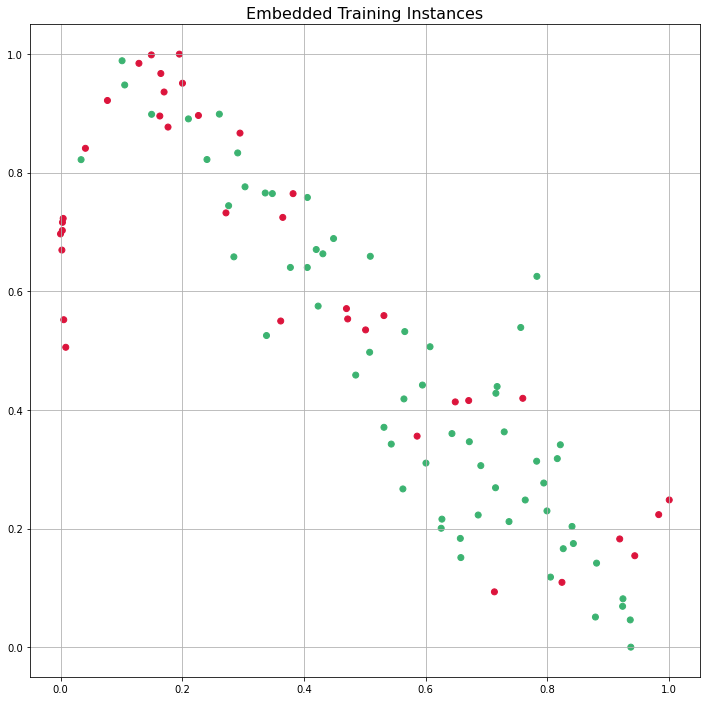

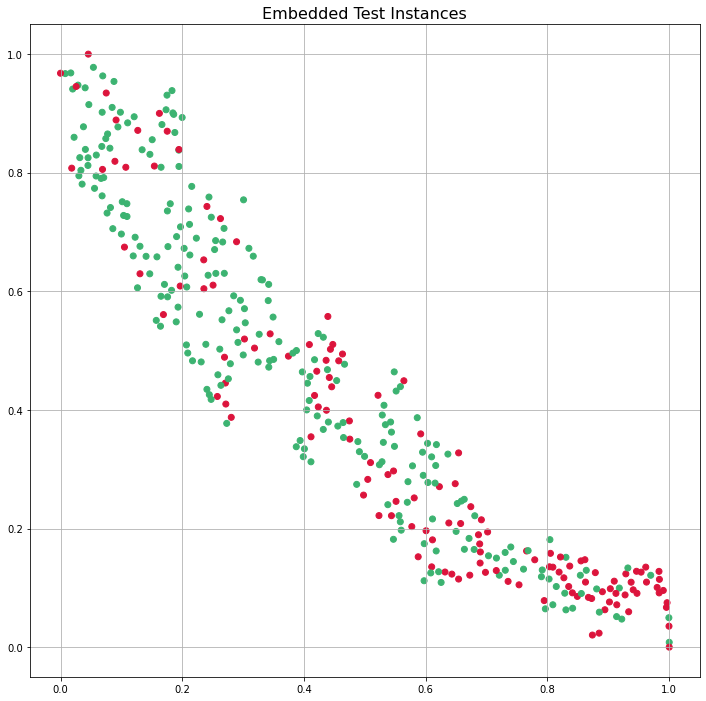

In [ ]:
plot_embedding(emb.encode(X_train), y_train, "Embedded Training Instances", f"drive/MyDrive/ColabData/Univariate_ts/{dataset_name}/embedded_training_set")
plot_embedding(emb.encode(X_test), y_test, "Embedded Test Instances", f"drive/MyDrive/ColabData/Univariate_ts/{dataset_name}/embedded_test_set")

In [ ]:
print(f"Train Silhoutte: {np.mean(train_sils):.4f} +/- {np.std(train_sils):.4f}")
print(f"Test Silhoutte: {np.mean(test_sils):.4f} +/- {np.std(test_sils):.4f}")

Train Silhoutte: 0.2564 +/- 0.0049
Test Silhoutte: 0.1610 +/- 0.0052


In [ ]:
print(f"1-NN Accuracy: {np.mean(one_accuracies):.4f} +/- {np.std(one_accuracies):.4f}")
print(f"3-NN Accuracy: {np.mean(three_accuracies):.4f} +/- {np.std(three_accuracies):.4f}")

1-NN Accuracy: 0.5865 +/- 0.0254
3-NN Accuracy: 0.6297 +/- 0.0058
